In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

avaliacoes = pd.read_csv("avaliacoes.csv", sep=",", encoding="utf-8")
clinicas = pd.read_csv("clinicas.csv", sep=",", encoding="utf-8")
consultas = pd.read_csv("consultas.csv", sep=",", encoding="utf-8")
medicos = pd.read_csv(
    "medicos.csv",
    sep=";", 
    encoding="utf-8",
    header=0,
    names=["id_medico", "nome_medico", "especialidade"]
)
pacientes = pd.read_csv("pacientes.csv", sep=",", encoding="utf-8")

consultas["data_hora_agendada"] = pd.to_datetime(consultas["data_hora_agendada"], errors="coerce")
consultas["data_hora_inicio"] = pd.to_datetime(consultas["data_hora_inicio"], errors="coerce")

clinicas["capacidade_diaria"] = pd.to_numeric(clinicas["capacidade_diaria"], errors="coerce")
avaliacoes["nota_satisfacao"] = pd.to_numeric(avaliacoes["nota_satisfacao"], errors="coerce")

consultas["tempo_espera"] = (consultas["data_hora_inicio"] - consultas["data_hora_agendada"]).dt.total_seconds() / 60
print(medicos.head())
print(medicos.columns)

# - Importei bibliotecas e carreguei os arquivos CSV
# - Converte datas para formato datetime
# - Converte colunas numéricas (capacidade, nota de satisfação)
# - Calcula tempo de espera em minutos entre horário agendado e início da consulta

In [ ]:
df = consultas.merge(pacientes, on="id_paciente", how="inner")
df = df.merge(medicos, on="id_medico", how="inner")
df = df.merge(clinicas, on="id_clinica", how="inner")
df = df.merge(avaliacoes, on="id_consulta", how="inner")

# Unificação das tabelas (consultas, pacientes, médicos, clínicas e avaliações) em um único DataFrame


In [ ]:
Q1 = df["tempo_espera"].quantile(0.25)
Q2 = df["tempo_espera"].quantile(0.50)
Q3 = df["tempo_espera"].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df["outlier_tempo_espera"] = (df["tempo_espera"] < limite_inferior) | (df["tempo_espera"] > limite_superior)

print("Quartis:")
print(f"Q1 = {Q1:.2f}, Q2 (mediana) = {Q2:.2f}, Q3 = {Q3:.2f}")
print(f"Limite inferior = {limite_inferior:.2f}, limite superior = {limite_superior:.2f}")

# Cálculo dos quartis e do IQR para identificar outliers no tempo de espera
# (valores muito abaixo ou acima dos limites definidos pelos quartis)


Quartis:
Q1 = 8.75, Q2 (mediana) = 30.00, Q3 = 180.00
Limite inferior = -248.12, limite superior = 436.88


In [ ]:
resumo = df.groupby(["especialidade_y", "id_medico", "id_clinica"]).agg(
    media_espera=("tempo_espera", "mean"),
    mediana_espera=("tempo_espera", "median"),
    media_nota=("nota_satisfacao", "mean"),
    mediana_nota=("nota_satisfacao", "median"),
    qtd_consultas=("id_consulta", "count")
).reset_index()

resumo = resumo.rename(columns={"especialidade_y": "especialidade"})

print("\nResumo por especialidade, médico e clínica:")
print(resumo.head())

# Agrupa por especialidade, médico e clínica
# Calcula média e mediana do tempo de espera
# Calcula média e mediana da nota de satisfação
# Conta a quantidade de consultas por grupo
# Renomeia coluna de especialidade para maior clareza



Resumo por especialidade, médico e clínica:
  especialidade  id_medico  id_clinica  media_espera  mediana_espera  \
0   Cardiologia         12          79         240.0           240.0   
1   Cardiologia         13          50          60.0            60.0   
2   Cardiologia         15          95          15.0            15.0   
3   Cardiologia         19          39          60.0            60.0   
4   Cardiologia         19          82          30.0            30.0   

   media_nota  mediana_nota  qtd_consultas  
0         2.0           2.0              1  
1         1.0           1.0              1  
2         5.0           5.0              1  
3         2.0           2.0              1  
4         1.0           1.0              1  


In [ ]:
correlacao = df[["tempo_espera", "nota_satisfacao"]].corr().iloc[0,1]
print(f"\nCorrelação entre tempo de espera e nota de satisfação: {correlacao:.3f}")

# Calcula a correlação entre tempo de espera e nota de satisfação
# para verificar se atrasos influenciam a avaliação dos pacientes
# 0,004 indica que o tempo de espera nao impacta nas notas de satisfação 



Correlação entre tempo de espera e nota de satisfação: -0.004


In [54]:
df["faixa_etaria"] = pd.cut(df["idade"], bins=[0,18,30,45,60,100], labels=["0-18","19-30","31-45","46-60","60+"])
#Separação por faixa etaria

insatisfacao = df.groupby(
    ["cidade_x", "faixa_etaria", "especialidade_y"]
)["nota_satisfacao"].mean().reset_index()
# Calcula a nota média por cidade, faixa etária e especialidade

reclamacoes = df.groupby("id_medico").agg(
    tempo_medio=("tempo_espera","mean"),
    nota_media=("nota_satisfacao","mean"),
    qtd_reclamacoes=("nota_satisfacao", lambda x: (x<=2).sum())
).reset_index()
#Analise de medica com tempo , media e quantidade de reclamaçao

clinica_cmp = df.groupby("id_clinica").agg(
    capacidade=("capacidade_diaria","first"),
    consultas_total=("id_consulta","count"),
    nota_media=("nota_satisfacao","mean")
).reset_index()
#COmpração de clina por capacidade , consultas e notas.

plano_cmp = df.groupby("plano_saude").agg(
    media_espera=("tempo_espera","mean"),
    media_nota=("nota_satisfacao","mean")
).reset_index()
# Analisa plano de saúde com média de tempo de espera e nota média por plano

taxa_cancel = df.groupby("especialidade_y").agg(
    taxa_cancelamento=("status", lambda x: (x=="Cancelada").mean()),
    nota_media=("nota_satisfacao","mean")
).reset_index()
# Calcula taxa de cancelamento e nota média por especialidade

C:\Users\Vinicius\AppData\Local\Temp\ipykernel_7756\3653320324.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insatisfacao = df.groupby(


In [55]:
import matplotlib.pyplot as plt

print("\n=== Insatisfação por cidade e faixa etária ===")
print(insatisfacao.head())

print("\n=== Médicos e reclamações ===")
print(reclamacoes.head())

print("\n=== Clínicas: capacidade vs desempenho ===")
print(clinica_cmp.head())

print("\n=== Plano de saúde vs espera ===")
print(plano_cmp)

print("\n=== Especialidades com cancelamento x nota ===")
print(taxa_cancel)


=== Insatisfação por cidade e faixa etária ===
         cidade_x faixa_etaria especialidade_y  nota_satisfacao
0  Belo Horizonte         0-18     Cardiologia              NaN
1  Belo Horizonte         0-18    Dermatologia              NaN
2  Belo Horizonte         0-18     Ginecologia              3.0
3  Belo Horizonte         0-18      Neurologia              NaN
4  Belo Horizonte         0-18       Ortopedia              NaN

=== Médicos e reclamações ===
   id_medico  tempo_medio  nota_media  qtd_reclamacoes
0          1   150.000000    2.500000                1
1          2   300.000000    3.000000                0
2          3   121.666667    3.666667                0
3          5    30.000000    5.000000                0
4          6    30.000000    4.000000                0

=== Clínicas: capacidade vs desempenho ===
   id_clinica  capacidade  consultas_total  nota_media
0           2          78                1         5.0
1           3          37                2         4.

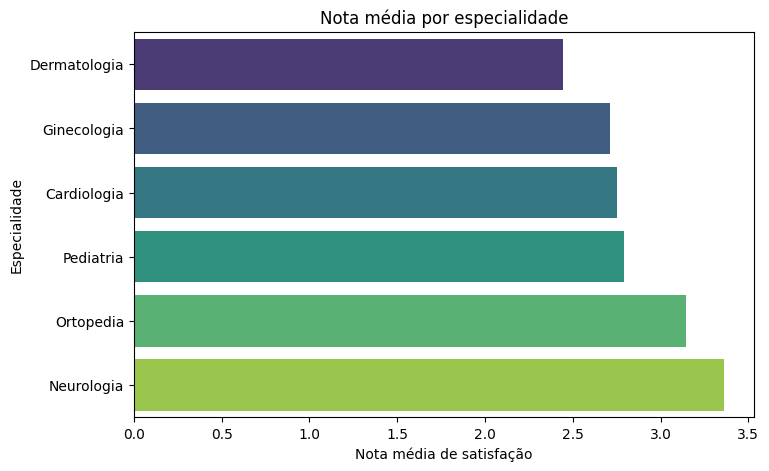

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=nota_especialidade.values,
    y=nota_especialidade.index,
    hue=nota_especialidade.index,
    palette="viridis",
    legend=False                  
)
plt.title("Nota média por especialidade")
plt.xlabel("Nota média de satisfação")
plt.ylabel("Especialidade")
plt.show()

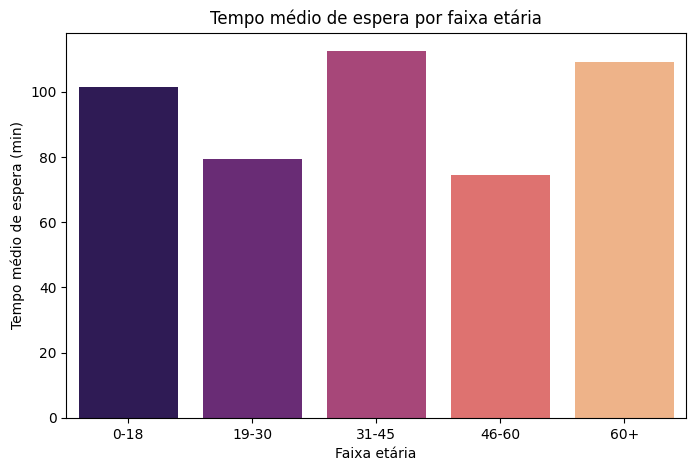

In [53]:
espera_faixa = (
    df.groupby("faixa_etaria", observed=True)["tempo_espera"]
      .mean()
      .reset_index()
)


plt.figure(figsize=(8,5))
sns.barplot(
    data=espera_faixa,
    x="faixa_etaria",
    y="tempo_espera",
    hue="faixa_etaria",   # adiciona como hue
    palette="magma",
    legend=False          # remove legenda desnecessária
)
plt.title("Tempo médio de espera por faixa etária")
plt.xlabel("Faixa etária")
plt.ylabel("Tempo médio de espera (min)")
plt.show()